In [1]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


# Data importation

In [2]:
# Load data from a JSON file

# Define the file path. Replace with the actual path to the file if different.
file_path = 'data/match_2.json'
# Load the JSON file into a pandas DataFrame with records orientation.
data = pd.read_json(file_path, orient='records')

# Display the first 5 rows of the data for a quick overview
print(data.head(-5))


         label                                               norm
0    no action  [104.42423889328715, 87.63989343949717, 128.52...
1          run  [108.03112639951678, 92.57566083451651, 81.303...
2         pass  [17.837163554142162, 39.435455203974186, 51.64...
3         rest  [21.91843920469922, 18.11914155706377, 21.7137...
4         walk  [20.86063916182152, 17.8097748446304, 14.35537...
..         ...                                                ...
603       walk  [26.163208826616533, 27.65027335817936, 32.828...
604       walk  [24.272591737201584, 23.34230473174291, 21.559...
605       walk  [24.17893669498924, 24.162416791614202, 24.183...
606       walk  [30.071500200661685, 38.25667068937918, 42.222...
607       walk  [25.129705887508944, 27.65027335817936, 36.960...

[608 rows x 2 columns]


In [3]:
# Display a summary of the dataset

# Get a concise summary of the DataFrame, including the number of non-null values in each column, data types, and memory usage.
data.info()
# Get descriptive statistics of the DataFrame columns.
data.describe()

# The output indicates:
# - The DataFrame has 613 entries (rows) ranging from index 0 to 612.
# - It has 2 columns: 'label' and 'norm', both of which are of object (string) data type.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   613 non-null    object
 1   norm    613 non-null    object
dtypes: object(2)
memory usage: 9.7+ KB


,label,norm
count,613,613
unique,9,613
top,run,"[104.42423889328715, 87.63989343949717, 128.52..."
freq,343,1


# Feature creation, time measure

count    613.000000
mean       0.913736
std        0.708673
min        0.060000
25%        0.640000
50%        0.800000
75%        1.080000
max       14.460000
Name: sec_time, dtype: float64


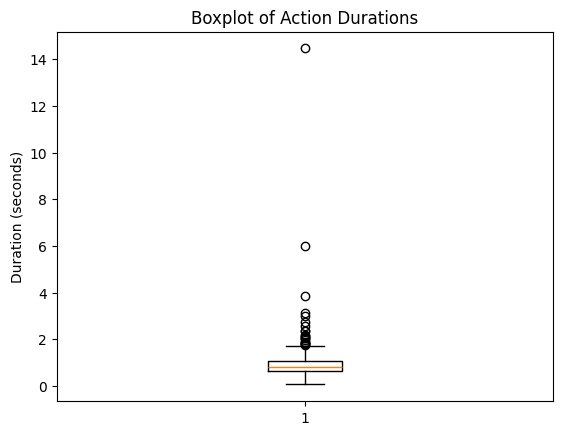

In [4]:
# Compute size of each list in 'norm' column
data['norm_length'] = data['norm'].apply(len)

# Convert size to time in seconds (assuming 50 Hz sampling rate)
data['sec_time']= data['norm_length']/50

# Calculate cumulative time in seconds
data['sec_time_cum'] = data['sec_time'].cumsum()

# Convert cumulative time to minutes
data['time_min']= data['sec_time_cum']/60

# Uncommented lines determine how many actions have a duration below 0.1 seconds or above 3 seconds:
# less_than_0_1 = (data['sec_time'] < 0.1).sum()
# greater_than_3 = (data['sec_time'] > 3).sum()

# print(f"Number of values less than 0.1: {less_than_0_1}")
# print(f"Number of values greater than 3: {greater_than_3}")

# Display statistics about the duration of actions in seconds
print(data['sec_time'].describe())

# Plot boxplot of action durations in seconds
plt.boxplot(data['sec_time'])
plt.ylabel('Duration (seconds)')
plt.title('Boxplot of Action Durations')
plt.show()


# The median action duration is 0.8 (match1: 0.92) seconds.
# 25% of the actions have a duration less than 0.64 (match1: 0.68) seconds (1st quartile).
# 75% of the actions take less than 1.08 (match 1: 1.16) seconds (3rd quartile).
# There are several outliers, with the max duration reaching up to 14.46 (match1: 4.54) seconds.

#No big differences, except max

# Label analysis

label
run          343
walk         190
dribble       36
shot          12
tackle        11
rest          10
pass           8
no action      2
cross          1
Name: count, dtype: int64


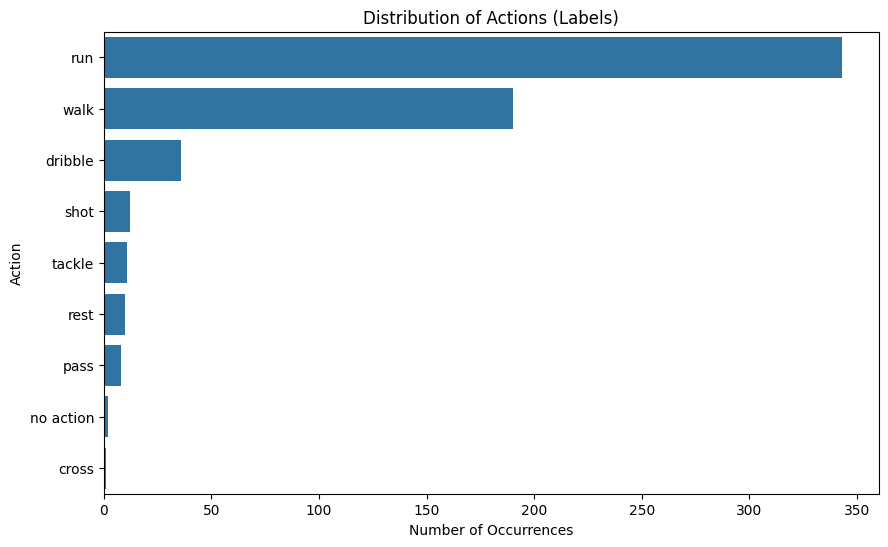

In [5]:
# Observe class imbalances
print(data['label'].value_counts())

# Plot distribution of action labels
plt.figure(figsize=(10,6))
sns.countplot(data=data, y='label', order=data['label'].value_counts().index)
plt.title('Distribution of Actions (Labels)')
plt.xlabel('Number of Occurrences')
plt.ylabel('Action')
plt.show()


#still walk and run are most frequent
# more shoot in this data file: 12 against 6 in match 1
# still, shoot, cross are rare action.

# This indicates a clear imbalance in the action distribution.
# Most of the time, player play without ball

# Statistical Analysis of norms by gait

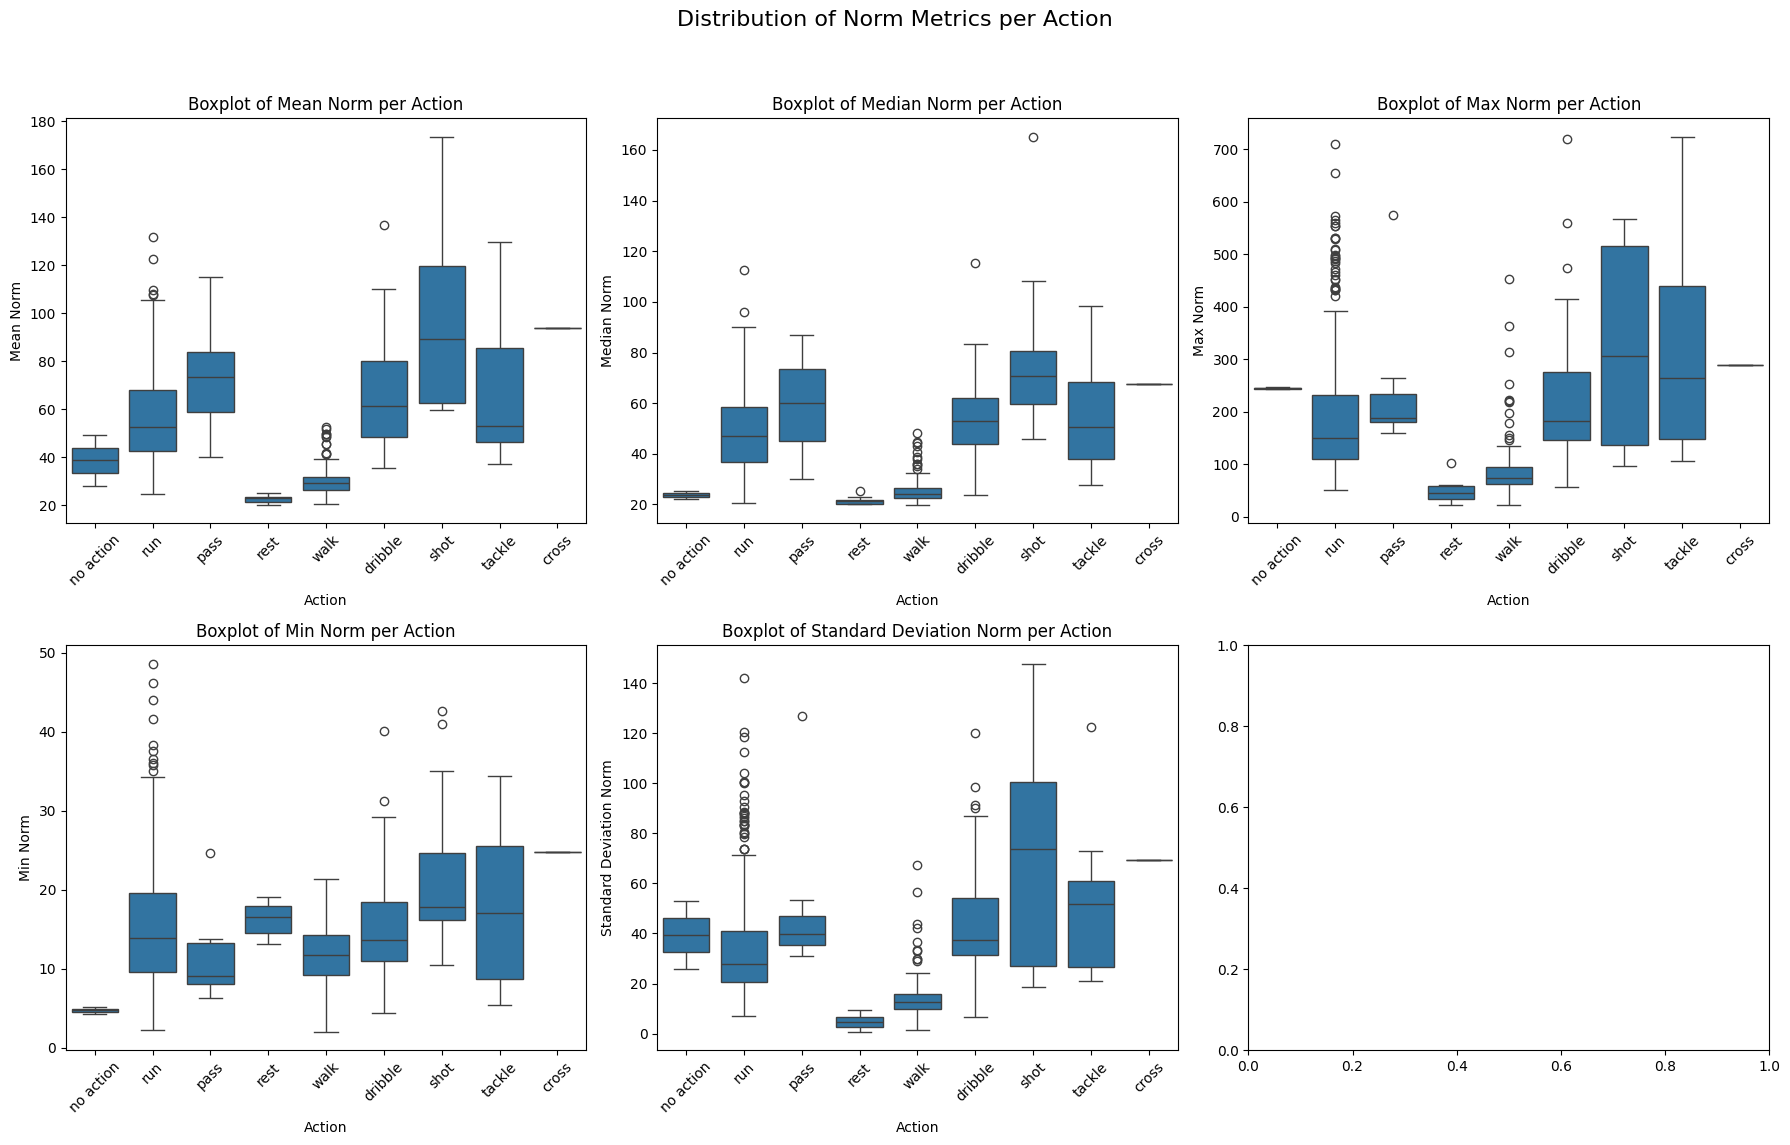

In [6]:
# Extract basic metrics for each norm sequence
data['mean_norm'] = data['norm'].apply(np.mean)
data['median_norm'] = data['norm'].apply(np.median)
data['max_norm'] = data['norm'].apply(max)
data['min_norm'] = data['norm'].apply(min)
data['std_norm'] = data['norm'].apply(np.std)

# Set up a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Norm Metrics per Action', fontsize=16)
axes = axes.flatten()  # Flattening the 2D axes array to easily iterate over it

# List of metrics and corresponding names for plotting
metrics = ['mean_norm', 'median_norm', 'max_norm', 'min_norm', 'std_norm']
titles = ['Mean', 'Median', 'Max', 'Min', 'Standard Deviation']

# Loop through metrics and titles to create a boxplot in each subplot
for i, (metric, title) in enumerate(zip(metrics, titles)):
    sns.boxplot(x='label', y=metric, data=data, ax=axes[i])
    axes[i].set_title(f'Boxplot of {title} Norm per Action')
    axes[i].set_xlabel('Action')
    axes[i].set_ylabel(f'{title} Norm')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Observations:
# 1. The mean norm for 'shot' is significantly higher than other actions.
# 2. Both 'shot' and 'dribble' have a wide range of norms, as indicated by their interquartile range (IQR).
# 3. 'Walk' and 'rest' have lower median norms compared to actions like 'run' or 'shot'.
# 4. There's a high standard deviation in norms for 'shot', suggesting varying intensity or style.
# 5. Outliers are present in several actions, which might be anomalies or extreme cases.

In [7]:
# Extract basic metrics for each norm sequence
data['mean_norm'] = data['norm'].apply(np.mean)
data['median_norm'] = data['norm'].apply(np.median)
data['min_norm'] = data['norm'].apply(min)
data['max_norm'] = data['norm'].apply(max)
data['std_norm'] = data['norm'].apply(np.std)

# Group by label and compute descriptive statistics for each group
grouped_stats = data.groupby('label').agg({
    'mean_norm': ['mean', 'std', 'min', 'median', 'max'],
    'median_norm': ['mean', 'std', 'min', 'median', 'max'],
    'std_norm': ['mean'],
    'min_norm': ['mean'],
    'max_norm': ['mean']
}).reset_index()

# Display the resulting DataFrame
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed
print(grouped_stats.round(3).T)


# The table presents a comprehensive view of the norm metrics across various actions.
# From the mean values of the mean_norm metric, the 'shot' action has the highest average norm value 98.465 ( match 1: 113.279), 
# while the 'rest' action has the lowest 22.712 ( match 1 : 21.834). This suggests that the 'shot' action tends to have more intense movements.
# Similarly, observing the mean values of the max_norm metric, 'shot' peaks at 321.913 (match 1: 438.247), further emphasizing its intensity.
# The 'rest' action, as expected, shows the least variability with a std_norm mean of just  1.682 (match 1: 3.783).
# The 'walk' and 'rest' actions have the lowest mean values for min_norm, indicating they start from a relatively low baseline.
# Overall, the table showcases the variance and central tendencies of norm metrics for each action, helping in understanding the nature of these actions.


#Overall we see that values from match 1 and match 2 are close:
#max run m1 = 201, max run m2= 192, mean m1= 54.405 and mean m2=56.225
#std shot m1 = 438.247 , max shot m2= 321.913, mean shot 1 = 113.279 and mean shot 2 =98.465
#maybe it is because the same person is wearing the sensor 

                          0        1          2        3       4        5  \
label                 cross  dribble  no action     pass    rest      run   
mean_norm   mean     93.892   65.564     38.652     73.0  22.712   56.225   
            std         NaN   21.573     15.098   25.512   1.682   19.056   
            min      93.892   35.299     27.977   40.089    20.1   24.504   
            median   93.892   61.151     38.652   73.242  23.019   52.464   
            max      93.892  136.956     49.328  115.015  25.128  131.888   
median_norm mean     67.704   54.007     23.659   59.148  21.496   48.659   
            std         NaN   17.227      2.201   21.201   1.627   15.935   
            min      67.704   23.553     22.103   29.877  20.005   20.427   
            median   67.704   52.955     23.659   60.228  21.236   47.063   
            max      67.704  115.322     25.215   86.819  25.316  112.742   
std_norm    mean     69.514   45.279     39.302    50.63   4.768   35.286   

# Statistical Analysis of last by gait

In [8]:
# Compute basic statistics for the specified column per action type
columns_to_describe = ['sec_time']
for column in columns_to_describe:
    print(f"Statistics for {column} grouped by Action:")
    print(data.groupby('label')[column].describe().round(3))
    print("\n")  # Adding a newline for better separation between results

# Observations based on the sec_time column grouped by Action:
# 1. 'rest' has the highest average sec_time 3.628 (match1 = 1.790), indicating the longest duration among the actions.
# 2. 'shot' has the shortest average sec_time 0.735 (match1 = 0.557), suggesting it is a quick action.
# 3. 'rest' also has the widest spread of sec_time values 4.106 (match1 = 1.180), indicating a high variability in rest durations.
# 4. The max sec_time for 'rest' is 14.46 (match 1 = 4.54), which is the longest single duration across all actions.

#again observation are very close,
# here maybe, we can asume that the people is more tired than in match 1

Statistics for sec_time grouped by Action:
           count   mean    std   min    25%   50%   75%    max
label                                                         
cross        1.0  0.600    NaN  0.60  0.600  0.60  0.60   0.60
dribble     36.0  0.731  0.353  0.06  0.515  0.68  0.93   1.88
no action    2.0  2.680  1.640  1.52  2.100  2.68  3.26   3.84
pass         8.0  1.008  0.618  0.52  0.560  0.61  1.57   2.04
rest        10.0  3.628  4.106  0.36  1.660  2.43  3.09  14.46
run        343.0  0.745  0.260  0.12  0.600  0.68  0.84   1.84
shot        12.0  0.735  0.380  0.12  0.410  0.75  0.98   1.32
tackle      11.0  0.998  0.668  0.40  0.600  0.76  1.04   2.36
walk       190.0  1.096  0.317  0.16  0.920  1.08  1.24   2.58




Basic statistics on the length of norm sequences grouped by Action:
           count        mean         std   min     25%    50%    75%    max
label                                                                      
cross        1.0   30.000000         NaN  30.0   30.00   30.0   30.0   30.0
dribble     36.0   36.527778   17.654601   3.0   25.75   34.0   46.5   94.0
no action    2.0  134.000000   82.024387  76.0  105.00  134.0  163.0  192.0
pass         8.0   50.375000   30.918961  26.0   28.00   30.5   78.5  102.0
rest        10.0  181.400000  205.291771  18.0   83.00  121.5  154.5  723.0
run        343.0   37.247813   12.976580   6.0   30.00   34.0   42.0   92.0
shot        12.0   36.750000   19.007774   6.0   20.50   37.5   49.0   66.0
tackle      11.0   49.909091   33.378000  20.0   30.00   38.0   52.0  118.0
walk       190.0   54.789474   15.854761   8.0   46.00   54.0   62.0  129.0




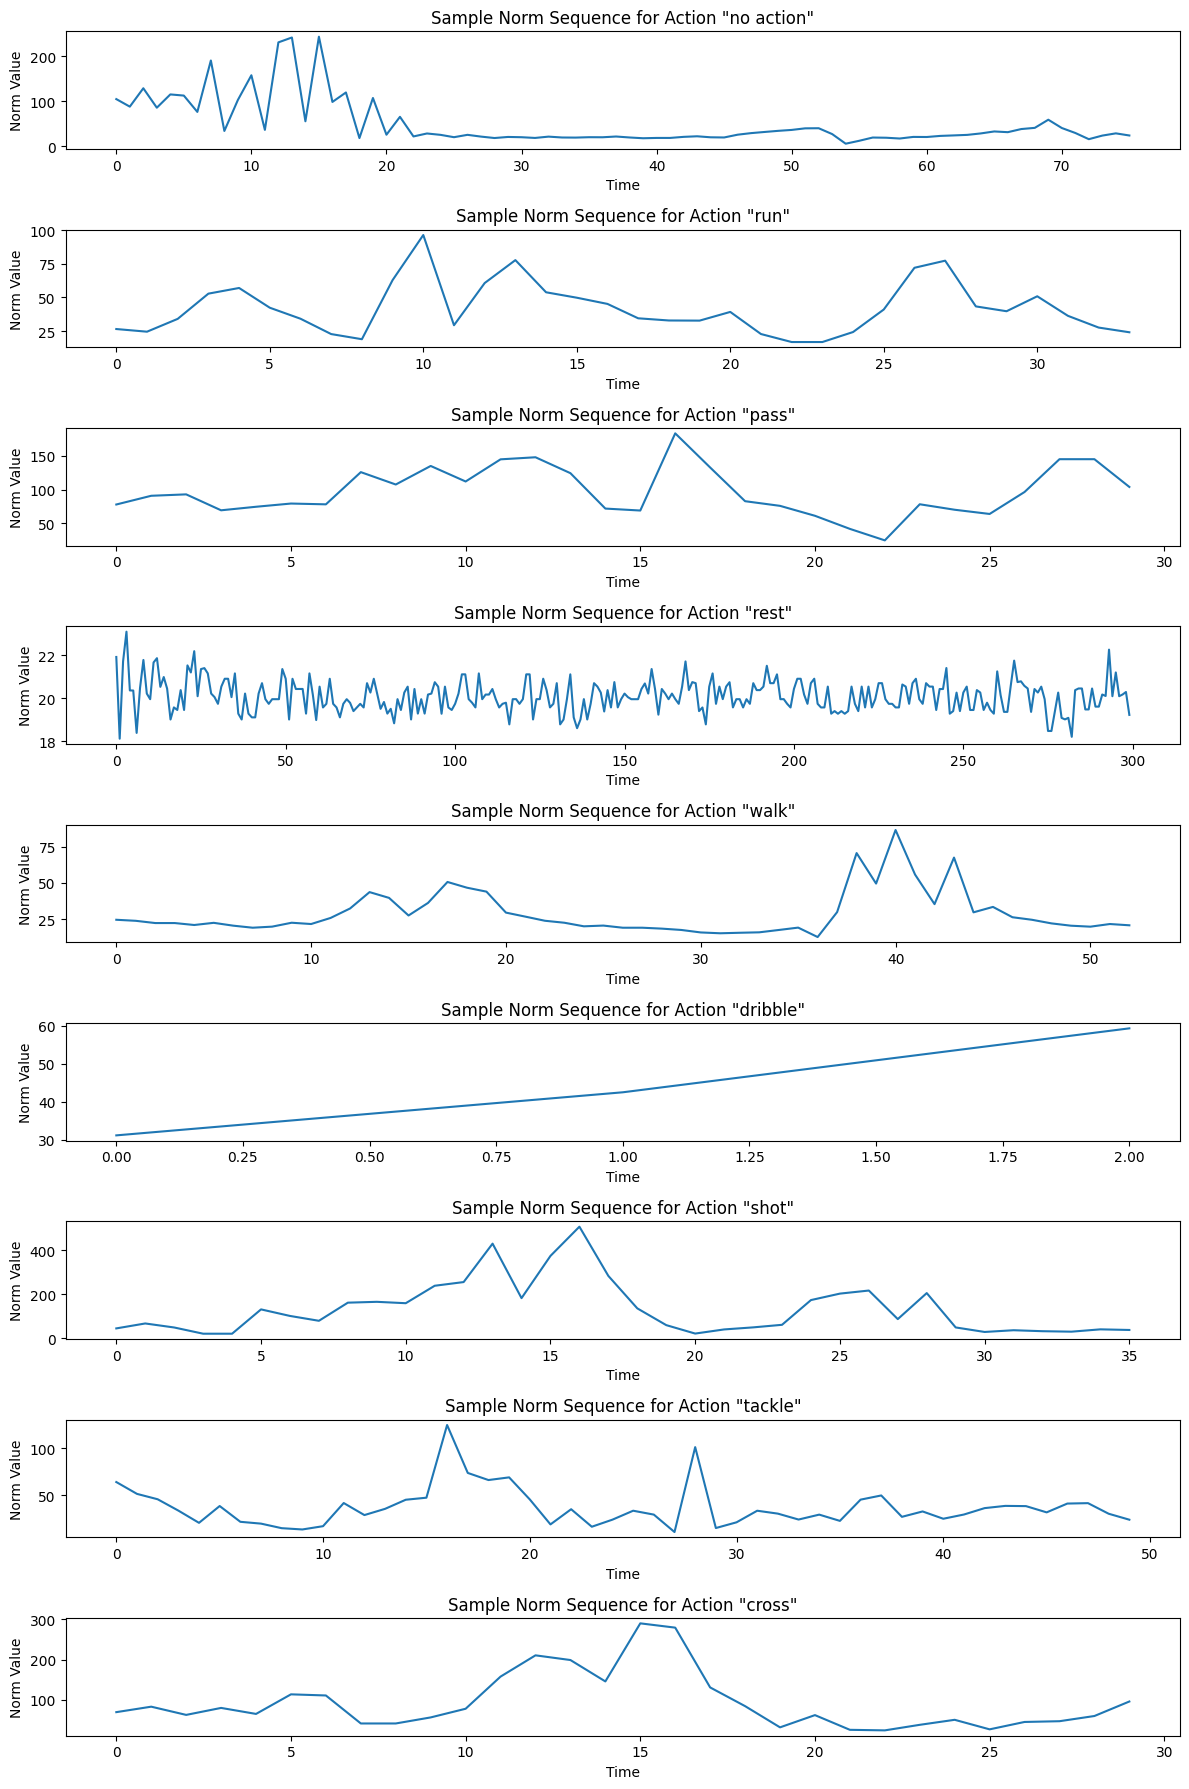

In [9]:
# Extract the length of each norm sequence
data['norm_length'] = data['norm'].apply(len)

# Compute basic statistics on the length of sequences for each action type
len_stats = data.groupby('label')['norm_length'].describe()
print("Basic statistics on the length of norm sequences grouped by Action:")
print(len_stats)
print("\n")  # Adding a newline for better separation between results

# Visualization of a sample norm sequence for each action type
actions = data['label'].unique()
fig, axs = plt.subplots(len(actions), figsize=(12, 2*len(actions)))

for ax, action in zip(axs, actions):
    # Select a random sequence for the current action type
    example_sequence = data[data['label'] == action]['norm'].sample(1).values[0]
    
    ax.plot(example_sequence)
    ax.set_title(f'Sample Norm Sequence for Action "{action}"')
    ax.set_xlabel('Time')
    ax.set_ylabel('Norm Value')

plt.tight_layout()
plt.show()




# Visualization of Mean Norm Across Indices with Action-specific Coloring

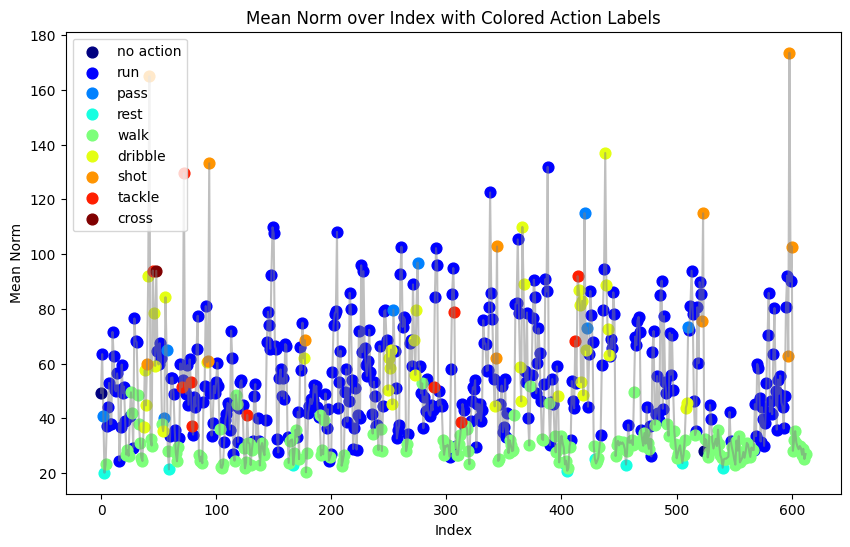

In [10]:
# Create a color dictionary for each unique label
labels = data['label'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(labels)))
color_map = dict(zip(labels, colors))

# Set up the plot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the line
ax.plot(data.index, data['mean_norm'], color='grey', alpha=0.5, linestyle='-', linewidth=1.5)

# Plot colored markers for each label
for label in labels:
    subset = data[data['label'] == label]
    ax.scatter(subset.index, subset['mean_norm'], label=label, color=color_map[label], s=60)

ax.set_xlabel('Index')
ax.set_ylabel('Mean Norm')
ax.set_title('Mean Norm over Index with Colored Action Labels')
ax.legend(loc='upper left')
plt.show()

# Observation:
# Peaks in the mean norm often correspond to high-intensity actions such as shots, pass, cross, tackles.
# walk, rest, run seems more regular less intense actions. 
# The distinguishing factor could likely be the length of the norm sequence.

#same observations


# Stance length analysis

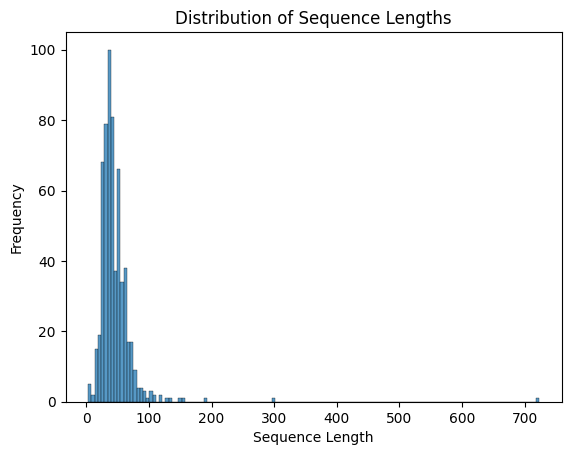

In [11]:
# Calculate the length of each norm sequence
data['norm_length'] = data['norm'].apply(len)

# Plot the distribution of the sequence lengths
sns.histplot(data['norm_length'])
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()


#the distribution of sequence lengths seems to follow a normal distribution
#The majority of sequence lengths fall within the 50 to 100 range, with the peak (mode) slightly below 100
# same observations

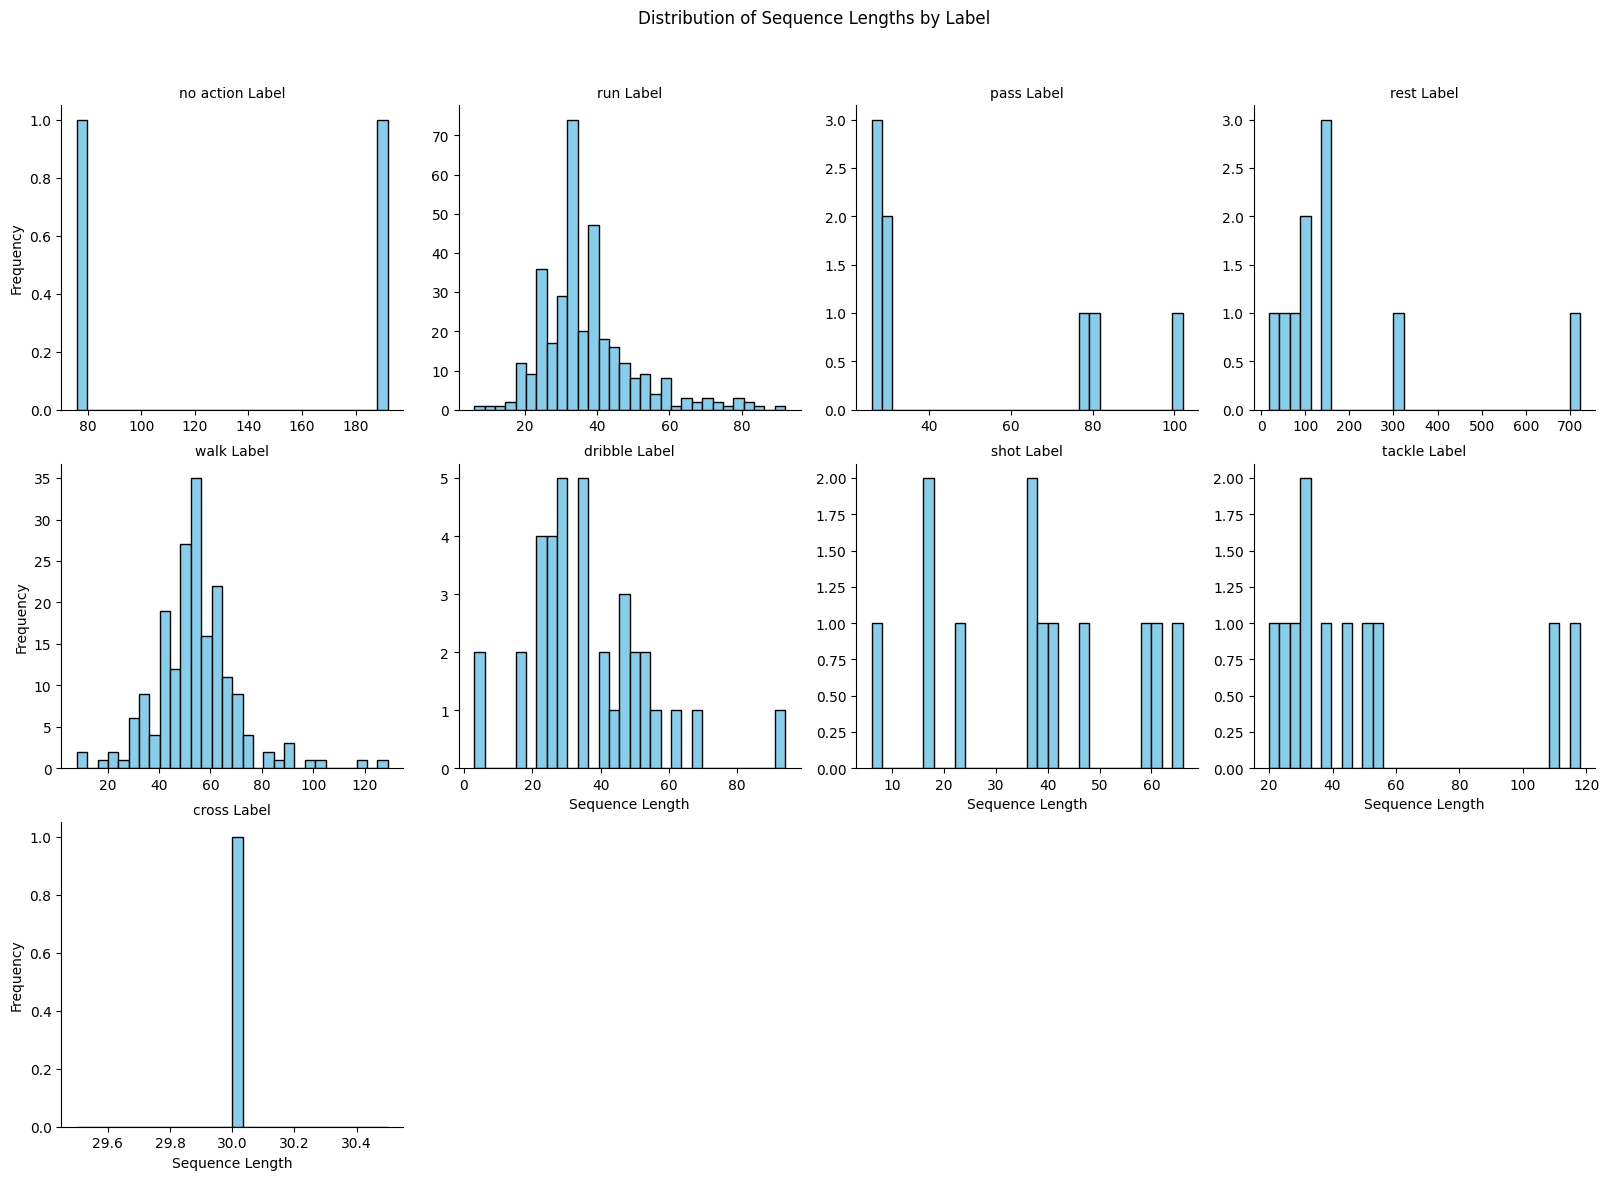

In [12]:
# Use FacetGrid to create a histogram for each label
g = sns.FacetGrid(data, col="label", col_wrap=4, sharey=False, sharex=False, height=4)
g.map(plt.hist, "norm_length", bins=30, color='skyblue', edgecolor="black")

g.set_titles(col_template="{col_name} Label")
g.set_axis_labels("Sequence Length", "Frequency")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Sequence Lengths by Label")

plt.show()


# Markov Chain Analysis for Action Transitions

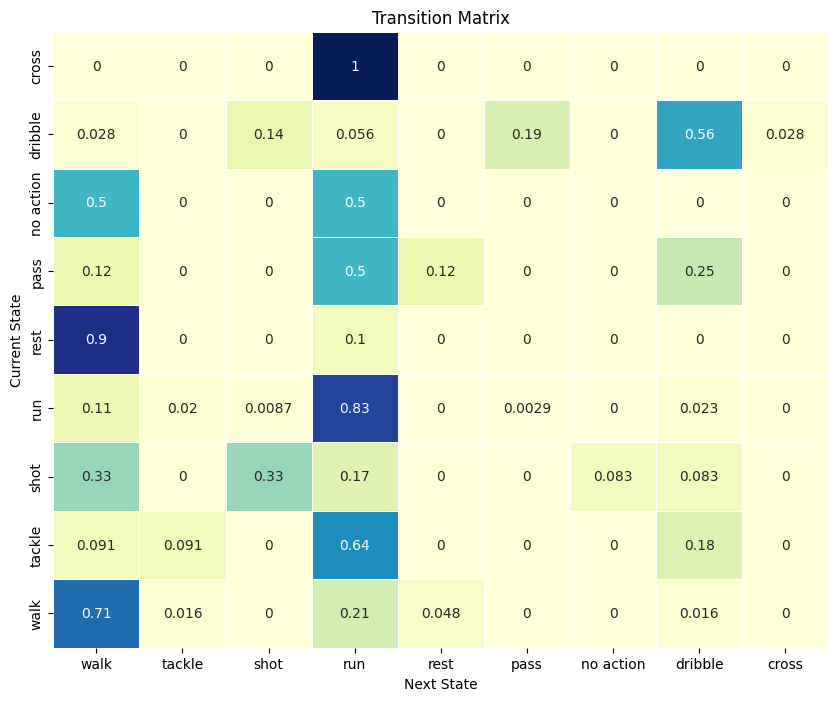

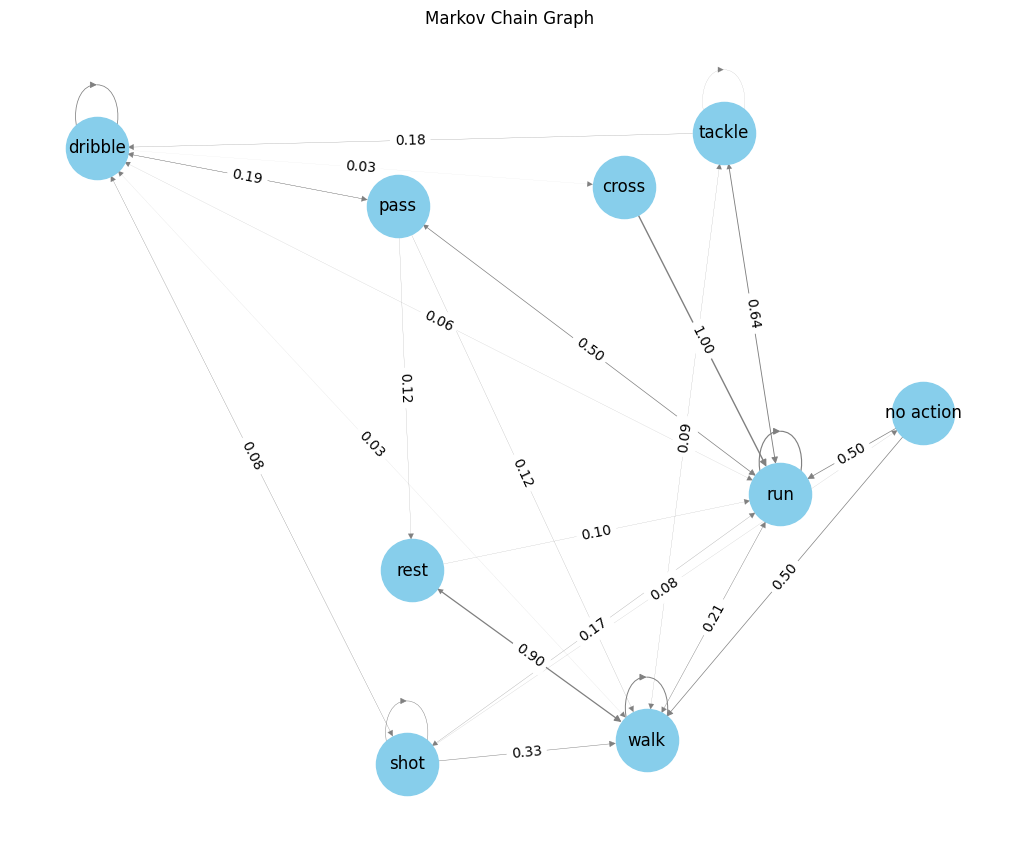

In [13]:
def compute_transition_frequencies(data):
    """
    Compute the frequency of transitions between different actions in the data.
    
    Args:
    - data (DataFrame): The dataset containing labeled sequences of actions.

    Returns:
    - matrix (dict): A dictionary representing the frequency of transitions 
                     between different actions.
    """
    matrix = {}  # Initialize an empty dictionary to hold transition frequencies.
    
    # Loop through each row of the data except the last one
    for i in range(len(data)-1):
        # Get the current action from the 'label' column
        current_action = data.iloc[i]['label']
        # Get the next action from the 'label' column
        next_action = data.iloc[i+1]['label']
        
        # Check if the current action is already in the matrix
        if current_action not in matrix:
            matrix[current_action] = {}  # If not, initialize it with an empty dictionary.
        
        # Check if the next action is already a key under the current action
        if next_action not in matrix[current_action]:
            matrix[current_action][next_action] = 1  # If not, initialize it with a count of 1.
        else:
            matrix[current_action][next_action] += 1  # If yes, increment the count.
    
    # Loop to normalize the transition counts to get transition probabilities
    for current_action, transitions in matrix.items():
        # Calculate the total count of transitions from the current action
        total = sum(transitions.values())
        # Normalize each count by the total
        for next_action, count in transitions.items():
            matrix[current_action][next_action] = count / total
    
    return matrix

def transition_frequencies_to_dataframe(transitions):
    """
    Convert the transition frequencies dictionary to a DataFrame.
    
    Args:
    - transitions (dict): A dictionary representing the frequency of transitions 
                          between different actions.

    Returns:
    - matrix (DataFrame): A dataframe representing the transition probabilities.
    """
    # Convert the dictionary of transition frequencies to a DataFrame
    matrix = pd.DataFrame().from_dict(transitions, orient='index').fillna(0)
    
    # Determine all unique actions present in either the rows or columns of the matrix
    all_actions = sorted(set(matrix.index) | set(matrix.columns))
    
    # Reindex the matrix to ensure all actions are represented in both rows and columns
    # Fill in any missing transitions with 0
    matrix = matrix.reindex(index=all_actions, columns=reversed(all_actions)).fillna(0)
    
    return matrix




def plot_transition_matrix(matrix):
    """
    Display the transition matrix as a heatmap.
    
    Args:
    - matrix (DataFrame): Transition matrix to be displayed.
    """
    # Set up the figure size for better visualization
    plt.figure(figsize=(10, 8))
    
    # Using seaborn's heatmap function to visualize the matrix
    sns.heatmap(matrix, annot=True, cmap='YlGnBu', cbar=False, linewidths=.5)
    
    # Setting the title and axis labels
    plt.title('Transition Matrix')
    plt.xlabel('Next State')
    plt.ylabel('Current State')
    
    # Display the plot
    plt.show()

def plot_markov_chain(transitions):
    """
    Display the Markov chain as a directed graph.
    
    Args:
    - transitions (dict): Dictionary of transition probabilities between states.
    """
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges to the graph based on the transition probabilities
    for action, next_actions in transitions.items():
        for next_action, prob in next_actions.items():
            G.add_edge(action, next_action, weight=prob)
    
    # Get positions for the nodes using spring layout
    pos = nx.spring_layout(G)
    
    # Create edge labels with transition probabilities
    edge_labels = {(u, v): "{:.2f}".format(d["weight"]) for u, v, d in G.edges(data=True)}
    
    # Set up the figure size for better visualization
    plt.figure(figsize=(10, 8))
    
    # Draw the graph with nodes, edges, and labels
    nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000, 
            width=[d["weight"] for _, _, d in G.edges(data=True)], edge_color="gray")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # Setting the title
    plt.title("Markov Chain Graph")
    
    # Display the plot
    plt.show()

# Use the build_transition_matrix function to get transition probabilities
transitions = compute_transition_frequencies(data)

# Convert the transition probabilities to a DataFrame for visualization
matrix = transition_frequencies_to_dataframe(transitions)

# Display the transition matrix as a heatmap
plot_transition_matrix(matrix)

# Display the Markov chain as a directed graph
plot_markov_chain(transitions)



#a lot of self transition probabilities, walk, run for example
# Diverse transitions: dribble leads to a lot of different transition
# zero transition: Several transitions have zero probabilities, implying no transition between certain states. cross to tackle for example
# Interesting patterns:
 # after a shot, there is almost equal probability to walk, shot or run
 
#same observation as match 1



## Summary of Matches 1 & 2

### Data Overview
Both matches present similar data structure with 'label' and 'norm' columns.

### Action Duration
The median action duration is slightly lower in match 2 (0.8s) compared to match 1 (0.92s). Outliers are present in both matches, with match 2 displaying a significantly longer max duration (14.46s vs. 4.54s in match 1).

### Action Distribution
Both matches predominantly feature 'walk' and 'run' actions. Match 2 shows an increase in 'shot' actions (12) compared to match 1 (6), yet actions like 'shot' and 'cross' remain rare. Overall, players mostly play without the ball.

### Intensity Metrics
'Shot' action consistently displays the highest intensity across both matches. The mean and max values for actions like 'run' and 'shot' are closely aligned between the two matches. A consistent person wearing the sensor could be the reason for the similarities.

### Action Durations
The 'rest' action's average duration is notably longer in match 2 (3.628s) than in match 1 (1.79s), indicating increased fatigue in the second match.

### Transition Patterns
Both matches show high self-transition probabilities, especially for 'walk' and 'run'. Diverse transitions post 'dribble' and consistent post 'shot' transitions are observed in both matches.

### Decision
Given the similarities in intensity, action distribution, and transition patterns, it's deemed beneficial to merge the data from both matches for richer insights and analyses.
